In [2]:
import os
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
from multiprocessing import Pool
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec

from matplotlib.patches import ConnectionPatch
from scipy.stats import fisher_exact

import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde, mannwhitneyu
from itertools import combinations

os.chdir('for_pub/Figure_4')
from Figure_4_module import *

In [3]:
#load splicing pickled data for plotting the ORFs
# Loading
with open('data_files/all.flair.collapse.isoforms_event_label_promoter_group_data.pkl', 'rb') as file:
    promoter_group_data = pickle.load(file)

In [5]:
gtf_file_path1 = 'data_files/all.flair.collapse.isoforms_event_label_start_stop_orf.gtf'

gtf_data_orf = pd.read_csv(gtf_file_path1, sep='\t',low_memory=False)



In [7]:
results_a_vs_c_splice = load_csv_as_dataframe('data_files/results_a_vs_c_splice.csv')
results_b_vs_d_splice = load_csv_as_dataframe('data_files/results_b_vs_d_splice.csv')


#load the AS event data table
asevents = pd.read_csv("data_files/ASevents_ovary.csv",sep="\t")
asevents.set_index('ids', inplace=True)

#merge the as events with the baysian table
splice_abundace_a_vs_c = pd.merge(results_a_vs_c_splice,asevents,left_index=True,right_index=True)
splice_abundace_b_vs_d = pd.merge(results_b_vs_d_splice,asevents,left_index=True,right_index=True)



#calculate the inclusion and exclusion event numbers
splice_abundace_a_vs_c = calculate_and_add_splicing_events(splice_abundace_a_vs_c)
splice_abundace_b_vs_d = calculate_and_add_splicing_events(splice_abundace_b_vs_d)

splice_abundace_a_vs_c = add_multi_trans_column_to_data(splice_abundace_a_vs_c,gtf_data_orf)
splice_abundace_b_vs_d = add_multi_trans_column_to_data(splice_abundace_b_vs_d,gtf_data_orf)

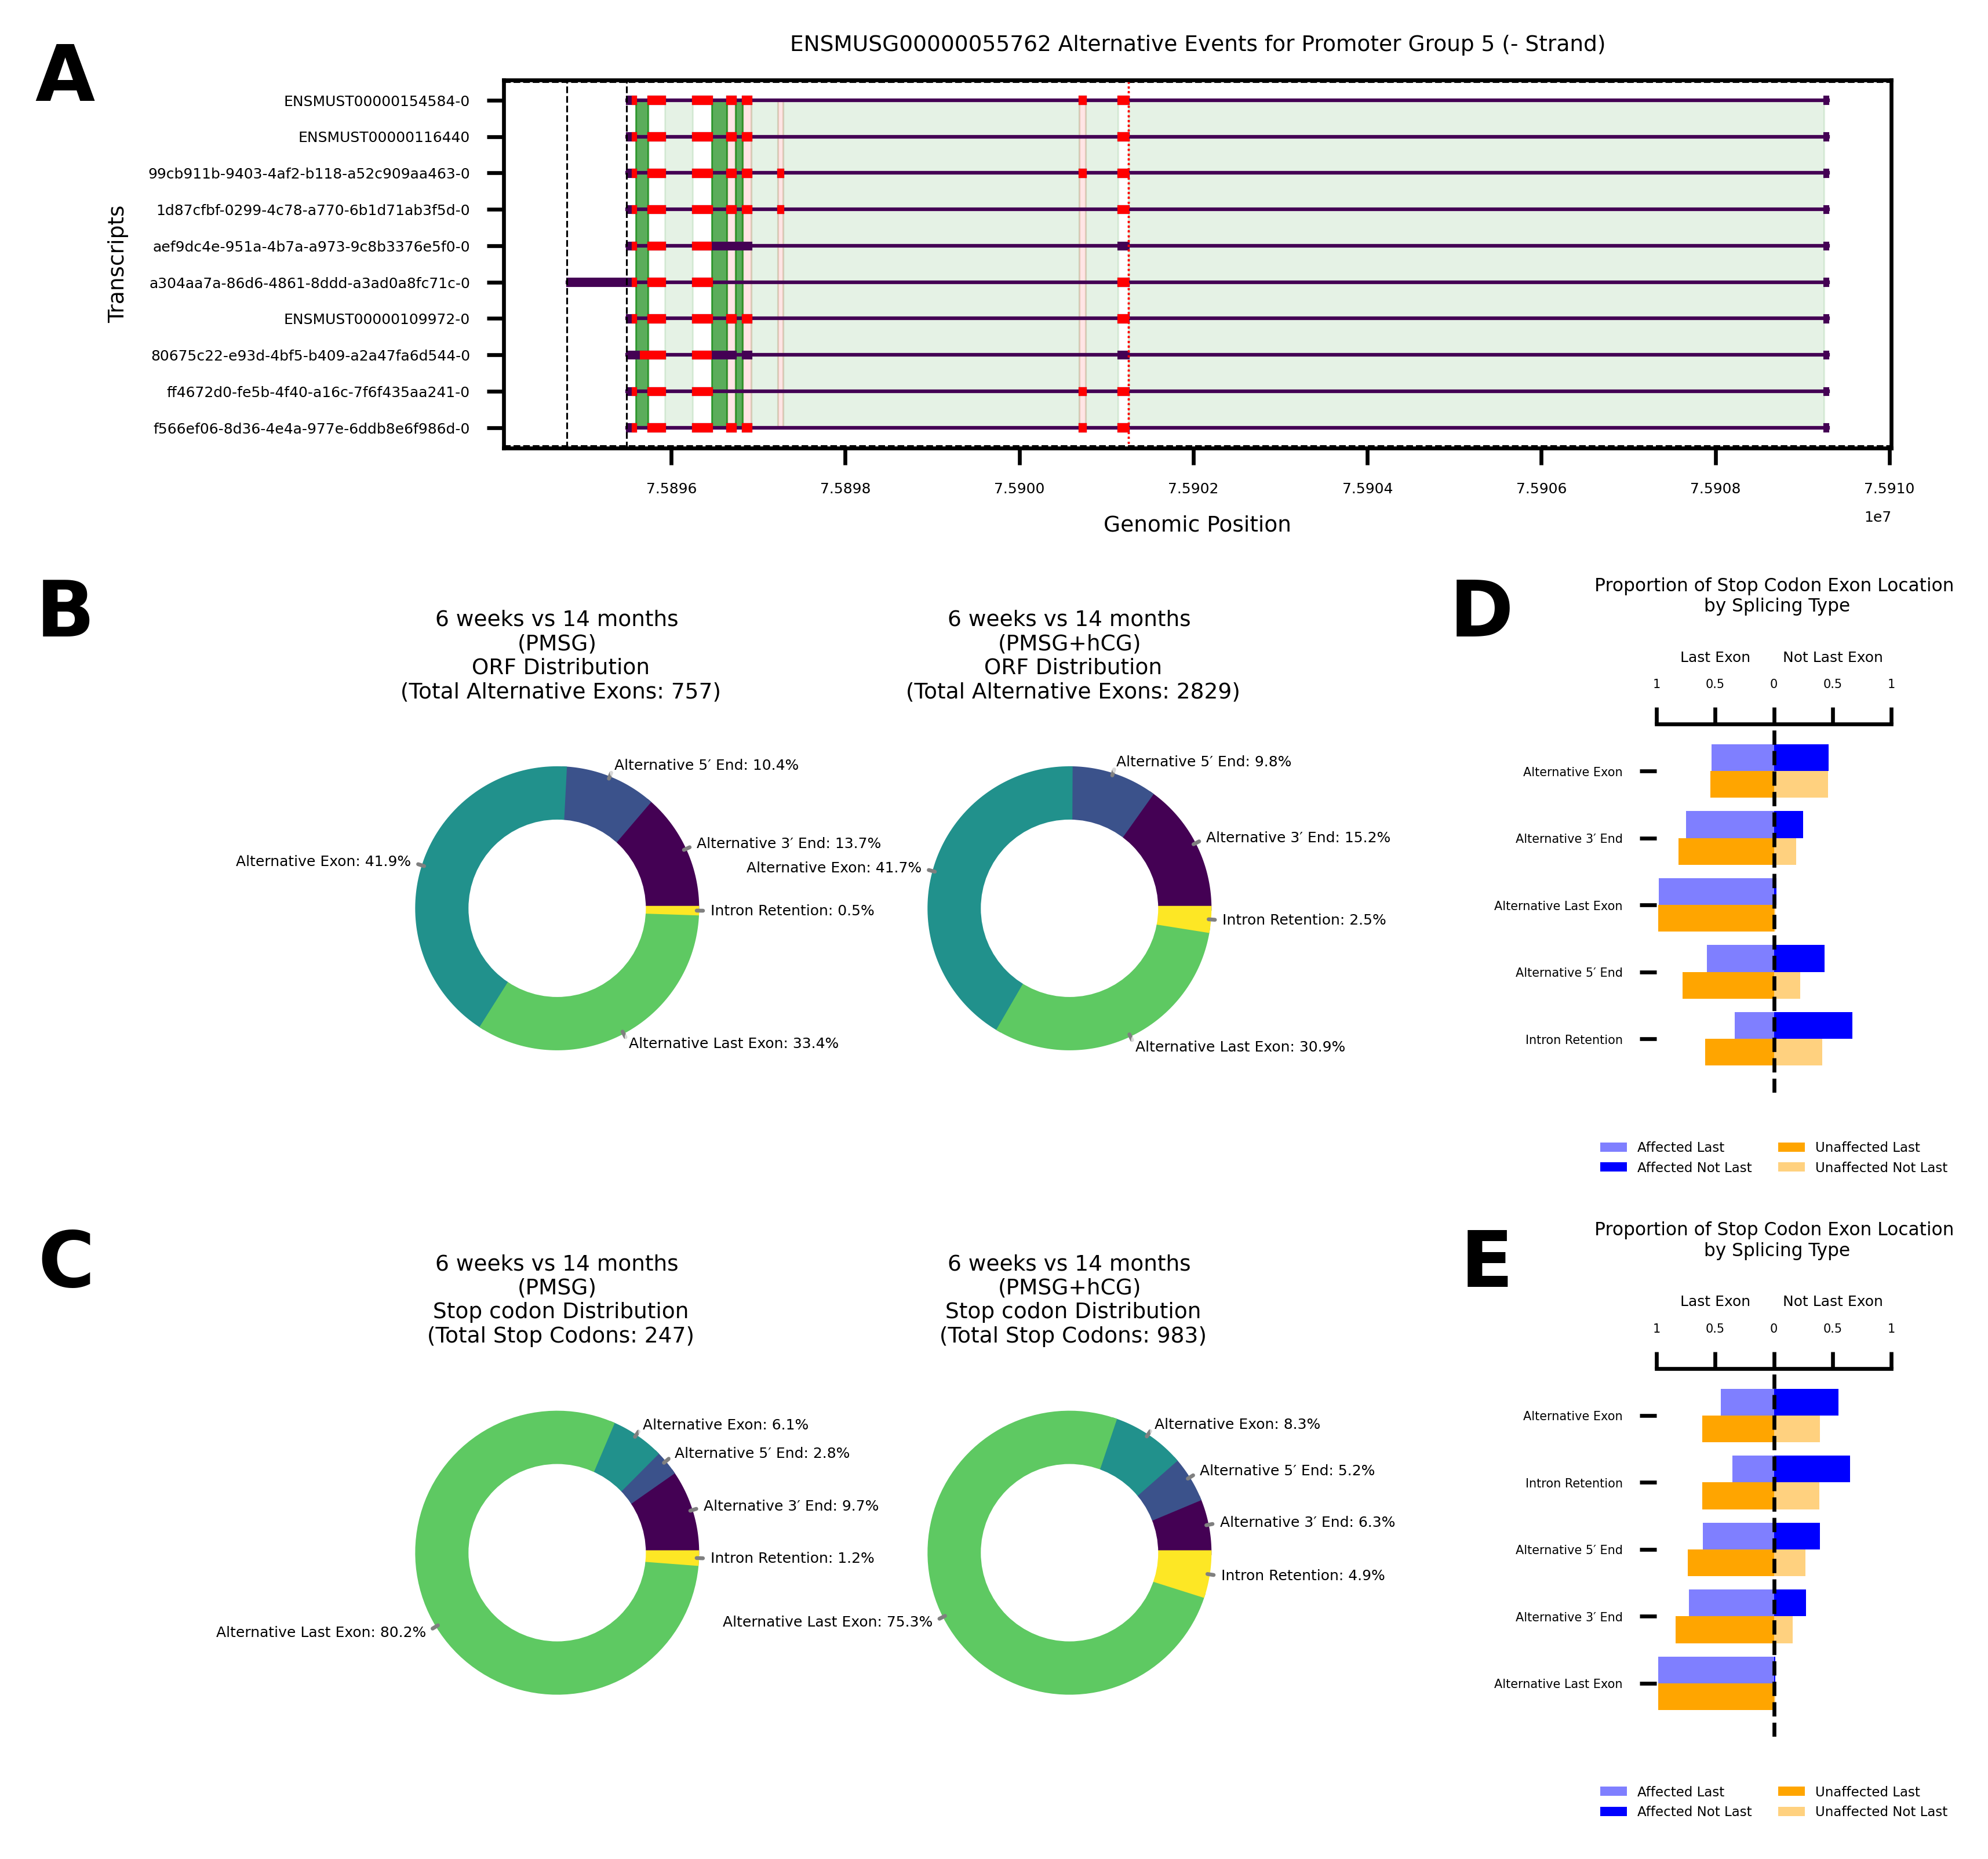

In [8]:

plt.rcParams['font.family'] = 'sans-serif'

# Prioritize 'Arial' within the 'sans-serif' font list
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']

fig = plt.figure(figsize=(8,11),dpi=600)

# Create a GridSpec with 2 rows of different heights and 2 columns
gs = gridspec.GridSpec(5, 17, height_ratios=[1,1,1,1,1], hspace=.75,wspace=.2, figure=fig)  # Example: [4, 1, 2] for 3 rows


# First row - two plots, each spanning two columns
ax1_1 = fig.add_subplot(gs[0, 2:13])
ax2 = fig.add_subplot(gs[1, 1:4])
ax3 = fig.add_subplot(gs[1, 5:8])
ax4 = fig.add_subplot(gs[1, 11:13])
ax5 = fig.add_subplot(gs[2, 1:4])
ax6 = fig.add_subplot(gs[2, 5:8])
ax8 = fig.add_subplot(gs[2, 11:13])

gene_id = 'ENSMUSG00000055762'
promoter_group_data_slice = find_all_promoter_groups_by_gene_id(promoter_group_data,gene_id)
#Specify the promoter group ID you want to plot
promoter_group_id_to_plot = 5


plot_promoter_group(
    promoter_group_data=promoter_group_data_slice,
    promoter_group_id_to_plot=promoter_group_id_to_plot,
    gtf_data=gtf_data_orf,
    gene_id=gene_id,
    ax_ae=ax1_1,       # Plot alternative events on ax1
    ax_cov=None,      # Plot coverage on ax2
    asplot=True,
    covplot=False,
    fscale1=3,
    fscale2=5,
    hide_xtick=False
)



ac_direction = get_updown(splice_abundace_a_vs_c,"both")
bd_direction = get_updown(splice_abundace_b_vs_d,"both")


asevents_ac = filter_and_count_features_orf(gtf_data_orf,ac_direction,'stop')
asevents_bd = filter_and_count_features_orf(gtf_data_orf,bd_direction,'stop')
asevents_ac_orf = filter_and_count_features_orf(gtf_data_orf,ac_direction,'orf')
asevents_bd_orf = filter_and_count_features_orf(gtf_data_orf,bd_direction,'orf')


event_name = ['Alternative Exon', 'Alternative 3′ End', 'Alternative 5′ End', 'Alternative Last Exon', 'Intron Retention']
event_column = ['ce', 'alt3', 'alt5', 'alt_end', 'ir']
# Define your title
title1 = "6 weeks vs 14 months\n(PMSG)\n Stop codon Distribution\n (Total Stop Codons"
title2 = "6 weeks vs 14 months\n(PMSG+hCG)\n Stop codon Distribution\n (Total Stop Codons"

title3 = "6 weeks vs 14 months\n(PMSG)\n ORF Distribution\n (Total Alternative Exons"
title4 = "6 weeks vs 14 months\n(PMSG+hCG)\n ORF Distribution\n (Total Alternative Exons"


# Call the corrected custom_pie_v4 function
custom_pie_v4(
    asevents=asevents_ac,
    title=title1,
    events='splice',
    event_name = event_name,         #custom event names 
    event_column = event_column,     #custom column names
    table_name='figure_files/stop_codon_by_splicing_a_vs_c_fig4_b_left.csv',  # Optional: specify your desired table name
    event_order=None,                 # Optional: specify a custom order if needed
    innerauto=False,                  # Disable inner labels for clarity
    outerauto=True,                   # Enable outer labels with leader lines
    innerman=False,                   # Do not manually place inner labels
    outerman=False,                   # Do not manually place outer labels
    legend=False,                      # Add a legend
    inner_pad=0.7,                    # Padding for inner labels (unused if innerauto=False)
    outer_pad=1.1,                    # Increased padding for outer labels
    fscale=3,
    axvis=False,                      # Hide axis
    ax=ax5,                          # Let the function create a new Axes
    table=True                       # Do not save the table as a CSV
)

# Call the corrected custom_pie_v4 function
custom_pie_v4(
    asevents=asevents_bd,
    title=title2,
    events='splice',
    event_name = event_name,         #custom event names 
    event_column = event_column,     #custom column names
    table_name='figure_files/stop_codon_by_splicing_b_vs_d_fig4_b_right.csv',  # Optional: specify your desired table name
    event_order=None,                 # Optional: specify a custom order if needed
    innerauto=False,                  # Disable inner labels for clarity
    outerauto=True,                   # Enable outer labels with leader lines
    innerman=False,                   # Do not manually place inner labels
    outerman=False,                   # Do not manually place outer labels
    legend=False,                      # Add a legend
    inner_pad=0.7,                    # Padding for inner labels (unused if innerauto=False)
    outer_pad=1.1,                    # Increased padding for outer labels
    fscale=3,
    axvis=False,                      # Hide axis
    ax=ax6,                          # Let the function create a new Axes
    table=True                       # Do not save the table as a CSV
)

# Call the corrected custom_pie_v4 function
custom_pie_v4(
    asevents=asevents_ac_orf,
    title=title3,
    events='splice',
    event_name = event_name,         #custom event names 
    event_column = event_column,     #custom column names
    table_name='figure_files/orf_by_splicing_a_vs_c_fig4_c_left.csv',  # Optional: specify your desired table name
    event_order=None,                 # Optional: specify a custom order if needed
    innerauto=False,                  # Disable inner labels for clarity
    outerauto=True,                   # Enable outer labels with leader lines
    innerman=False,                   # Do not manually place inner labels
    outerman=False,                   # Do not manually place outer labels
    legend=False,                      # Add a legend
    inner_pad=0.7,                    # Padding for inner labels (unused if innerauto=False)
    outer_pad=1.1,                    # Increased padding for outer labels
    fscale=3,
    axvis=False,                      # Hide axis
    ax=ax2,                          # Let the function create a new Axes
    table=True                       # Do not save the table as a CSV
)

# Call the corrected custom_pie_v4 function
custom_pie_v4(
    asevents=asevents_bd_orf,
    title=title4,
    events='splice',
    event_name = event_name,         #custom event names 
    event_column = event_column,     #custom column names
    table_name='figure_files/orf_by_splicing_b_vs_d_fig4_c_right.csv',  # Optional: specify your desired table name
    event_order=None,                 # Optional: specify a custom order if needed
    innerauto=False,                  # Disable inner labels for clarity
    outerauto=True,                   # Enable outer labels with leader lines
    innerman=False,                   # Do not manually place inner labels
    outerman=False,                   # Do not manually place outer labels
    legend=False,                      # Add a legend
    inner_pad=0.7,                    # Padding for inner labels (unused if innerauto=False)
    outer_pad=1.1,                    # Increased padding for outer labels
    fscale=3,
    axvis=False,                      # Hide axis
    ax=ax3,                          # Let the function create a new Axes
    table=True                       # Do not save the table as a CSV
)

event_names = ['Alternative Exon', 'Alternative 3′ End', 'Alternative 5′ End',
               'Alternative Last Exon', 'Intron Retention']
event_columns = ['ce', 'alt3', 'alt5', 'alt_end', 'ir']

# Define your bd_direction using get_updown
bd_not_direction = get_updown(splice_abundace_b_vs_d, "not")
# Define your bd_direction using get_updown
bd_both_direction = get_updown(splice_abundace_b_vs_d, "both")
# Call the function
result_bd_df_not_affected = analyze_direction(gtf_data_orf, bd_not_direction,keywords=event_columns, event_names=event_names)
result_bd_df_both_affected = analyze_direction(gtf_data_orf, bd_both_direction,keywords=event_columns, event_names=event_names)

event_names = ['Alternative Exon', 'Alternative 3′ End', 'Alternative 5′ End',
               'Alternative Last Exon', 'Intron Retention']
event_columns = ['ce', 'alt3', 'alt5', 'alt_end', 'ir']

# Define your bd_direction using get_updown
ac_not_direction = get_updown(splice_abundace_a_vs_c, "not")
# Define your bd_direction using get_updown
ac_both_direction = get_updown(splice_abundace_a_vs_c, "both")
# Call the function
result_ac_df_not_affected = analyze_direction(gtf_data_orf, ac_not_direction,keywords=event_columns, event_names=event_names)
result_ac_df_both_affected = analyze_direction(gtf_data_orf, ac_both_direction,keywords=event_columns, event_names=event_names)

# Example usage with affected and unaffected DataFrames

fisher_results_fig4_c = custom_horizontal_bar_chart_with_fisher(result_ac_df_both_affected, result_ac_df_not_affected, fscale=2.5, ax=ax4)
fisher_results_fig4_e = custom_horizontal_bar_chart_with_fisher(result_bd_df_both_affected, result_bd_df_not_affected, fscale=2.5, ax=ax8)
fisher_results_fig4_c.to_csv("figure_files/fisher_results_fig4_d.tsv",sep="\t")
fisher_results_fig4_e.to_csv("figure_files/fisher_results_fig4_e.tsv",sep="\t")

# Define the splicing event types
splicing_types = ['Alternative Exon', 'Alternative 5′ End', 'Alternative 3′ End', 'Intron Retention', 'Alternative Last Exon']
#splicing_types = ['Alternative Exon', 'Alternative 5′ End', 'Alternative 3′ End', 'Intron Retention', 'Alternative Last Exon']
# Initialize results dictionary
chi2_results_all_types = {'Panel B': {}, 'Panel C': {}}

# Perform chi-squared test for each splicing event type in Panel B and Panel C
for splicing_type in splicing_types:
    chi2_b, p_b = perform_chi_squared_test('figure_files/stop_codon_by_splicing_a_vs_c_fig4_b_left.csv', 'figure_files/stop_codon_by_splicing_b_vs_d_fig4_b_right.csv', splicing_type)
    chi2_d, p_d = perform_chi_squared_test('figure_files/orf_by_splicing_a_vs_c_fig4_c_left.csv', 'figure_files/orf_by_splicing_b_vs_d_fig4_c_right.csv', splicing_type)
    
    chi2_results_all_types['Panel B'][splicing_type] = (chi2_b, p_b)
    chi2_results_all_types['Panel C'][splicing_type] = (chi2_d, p_d)

# Convert results to DataFrame
chi2_results_df = pd.DataFrame(chi2_results_all_types).T.applymap(lambda x: f"{x[0]:.5f}, {x[1]:.5e}")

chi2_results_df
chi2_results_df.to_csv("figure_files/fig4_b_c_chi_results.tsv",sep="\t")


fig.text(0.07, 0.89, 'A', fontsize=16, fontweight='bold', va='top', ha='right', transform=fig.transFigure)
fig.text(0.07, 0.75, 'B', fontsize=16, fontweight='bold', va='top', ha='right', transform=fig.transFigure)
fig.text(0.58, 0.75, 'D', fontsize=16, fontweight='bold', va='top', ha='right', transform=fig.transFigure)
fig.text(0.07, 0.58, 'C', fontsize=16, fontweight='bold', va='top', ha='right', transform=fig.transFigure)
fig.text(0.58, 0.58, 'E', fontsize=16, fontweight='bold', va='top', ha='right', transform=fig.transFigure)
#fig.text(0.07, 0.475, 'F', fontsize=16, fontweight='bold', va='top', ha='right', transform=fig.transFigure)


fig.savefig('figure_files/Figure_4.png', dpi=600)
fig.savefig('figure_files/Figure_4.pdf', dpi=600)
plt.show()

#fisher_results_with_groups = analyze_splicing(results_df_affected, results_df_not_affected,ax=ax4)